In [1]:
import pandas as pd
import numpy as np
from pyspark.ml.feature import Word2Vec, Word2VecModel
from pyspark.ml.classification import (
    LogisticRegression,
    MultilayerPerceptronClassifier,
    LogisticRegressionModel,
    MultilayerPerceptronClassificationModel,
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType
import random

spark = SparkSession.builder.getOrCreate()
# ps.set_option("plotting.backend", "matplotlib")

In [2]:
data = pd.read_json("iota.json")
print("Success")
data

Success


,title,link,category,question_title,answer
0,How to get ALL NFTs form a 'collectionId' on S...,/questions/2952/how-to-get-all-nfts-form-a-col...,"[iota-network, shimmer]",NaN,NaN
1,IOTA indexed messages using IOTA address,/questions/2947/iota-indexed-messages-using-io...,[shimmer],NaN,NaN
2,How to store data from IoT machine on private ...,/questions/2944/how-to-store-data-from-iot-mac...,"[hornet, shimmer, private-network, inx]",NaN,NaN
3,How to specify a message or tag within a trans...,/questions/2940/how-to-specify-a-message-or-ta...,"[transaction, iota-network, microtransaction, ...",NaN,NaN
4,iota_wallet.common.IotaWalletError while synch...,/questions/2937/iota-wallet-common-iotawallete...,"[python, shimmer, wallet.rs]",NaN,NaN
...,...,...,...,...,...
3385,NaN,NaN,NaN,Is there a way to sign a transaction?,[This snipped shows how to sign a transaction ...
3386,NaN,NaN,NaN,How to keep track of an NFT or a collection of...,[]
3387,NaN,NaN,NaN,How to keep track of an NFT or a collection of...,[The indexer is the easiest way.\nUse the corr...
3388,NaN,NaN,NaN,How can I access and modify the state of that ...,[]


In [3]:
files = ["iota.json", "economics.json", "monero.json", "magento.json", "quant.json", "bitcoin2.json", "money.json", "ethereum.json"]
#all the classes used to classify
classes = []
#contains the full dataset
# class_col = []
class_index = []
df_full_np = np.empty((1,data.shape[1]))
cnt=0
for file in files:
    ind = file.find(".")
    c = file[:ind]
    classes.append(c)
    df = pd.read_json(file)
#     class_col += [c]*df.shape[0]
    class_index += [cnt]*df.shape[0]
    df_full_np = np.concatenate((df_full_np, df.to_numpy()), axis=0)
    cnt+=1
#     print(cnt)
print(df_full_np.shape)



#all the classes used to classify
# classes = []

# #contains the full dataset
# df_full = ps.DataFrame()
# class_index = 0
# for file in files:
#     ind = file.find(".")
#     c = file[:ind]
#     classes.append(c)
#     df = ps.read_json(file)
#     class_col = [c]*df.shape[0]
#     class_index_col = [class_index]*df.shape[0]
#     df['class'] = class_col
#     df['class_index'] = class_index_col
#     df=df.drop(['_corrupt_record'], axis=1)
#     df_full = df_full.append(df)
#     class_index += 1


# df_full.shape

(520959, 5)


In [ ]:
# categories_dict = collections.defaultdict(int)
# categories_list = df_full[df_full.category.notnull()]['category'].tolist()
# for categories in categories_list:
#     for c in categories:
#         categories_dict[c]+=1
# print(categories_dict)

In [ ]:
# sorted_categories = dict(sorted(categories_dict.items(), key=lambda item: -item[1]))
# top_k = 10
# categories = ps.DataFrame({'category': list(sorted_categories.keys())[:top_k], 'occurrences': list(sorted_categories.values())[:top_k]})
# ax = categories.plot(kind='barh', x='category', y='occurrences')

In [4]:
#title and question_title datasets
df_full_pd = pd.DataFrame(df_full_np[1:,:], columns = data.columns.values.tolist())
df_full_pd['class_index']=class_index
df_full_pd.shape

(520958, 6)

In [5]:
df_t_pd = df_full_pd[df_full_pd.title.notnull()][['title','class_index']]
df_t_np = df_t_pd.to_numpy()
df_qt_pd = df_full_pd[df_full_pd.question_title.notnull()][['question_title','answer']]
df_qt_np = df_qt_pd.to_numpy()
df_qt_np = [row for row in df_qt_np if len(row[1])>0]
df_qt_np = np.array(df_qt_np)
df_qt_pd = pd.DataFrame(df_qt_np, columns=['question_title','answer'])

In [6]:
#full dataset
random.shuffle(df_t_np)
n = len(df_t_np)

embedding_data = df_t_np[:int(0.5*n)]
classification_data = df_t_np[int(0.5*n):]
print("size of embedding data: {} \nsize of classification data: {}".format(len(embedding_data), len(classification_data)))

size of embedding data: 88697 
size of classification data: 88697


In [7]:
words = []
for title, class_index in embedding_data:
    words.append((title.split(" "), ))
words = spark.createDataFrame(words, ["sentence"])
words.show()

+--------------------+
|            sentence|
+--------------------+
|[How, to, get, AL...|
|[IOTA, indexed, m...|
|[How, to, get, AL...|
|[How, to, specify...|
|[How, to, specify...|
|[IOTA, indexed, m...|
|[IOTA, indexed, m...|
|[IOTA, indexed, m...|
|[IOTA, indexed, m...|
|[How, to, do, a, ...|
|[Tips, selection,...|
|[How, do, I, get,...|
|[Getting, error, ...|
|[How, to, store, ...|
|[Smart, contract,...|
|[How, to, keep, t...|
|[How, do, I, pass...|
|[Iota, explorer, ...|
|[Getting, error, ...|
|[IOTA, learning, ...|
+--------------------+
only showing top 20 rows



In [8]:
w2v = Word2Vec(vectorSize=5, seed=42, inputCol='sentence', outputCol='model', maxIter=10, minCount=0)
w2vModel = w2v.fit(words)
w2vModel.getVectors().show()
w2vModel.save("w2v.model")
print("Number of vectors acquired {}".format(w2vModel.getVectors().count()))

d:\anaconda\envs\tf-gpu\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+--------------------+
|                word|              vector|
+--------------------+--------------------+
|       specifically,|[-0.4890068471431...|
|          "Timestamp|[-0.0986907184123...|
|              Talent|[-0.1907614767551...|
|     "new-Keynesian"|[-0.1346144527196...|
|   government/public|[0.31715291738510...|
|          soft-forks|[-0.0919339433312...|
|              (GLMM)|[0.22814911603927...|
|          additivity|[0.12582439184188...|
|      Pareto-Optimal|[-0.1132052689790...|
|           MIgartion|[0.01588429324328...|
|             serious|[-0.3577447533607...|
|              comply|[0.56202989816665...|
|              breaks|[-0.2461587339639...|
|                 dns|[-0.4756813943386...|
|           forgotten|[0.24789668619632...|
|           altruism"|[-0.0792674645781...|
|855996c9444827112...|[-0.3040251731872...|
|            precious|[-0.4048662185668...|
|            activley|[0.08287889510393...|
|                   E|[-0.523583

In [9]:
#use embedding on classification data
words = []
for title, class_index in classification_data:
    words.append((title.split(" "), ))
transformed_rows = spark.createDataFrame(words, ["sentence"])
w2v_checkpoint = "w2v.model"
w2vModel = Word2VecModel.load(w2v_checkpoint)
embeddings = w2vModel.transform(transformed_rows)

In [10]:
embeddings.show()

+--------------------+--------------------+
|            sentence|               model|
+--------------------+--------------------+
|[Do, free-trade, ...|[-0.1578761285377...|
|[Calculating, nom...|[-0.6280010342597...|
|[What, is, the, n...|[-0.4166705020599...|
|[How, to, get, th...|[0.06733547756448...|
|[Software, wallet...|[-0.4243574813008...|
|[What, is, the, P...|[-0.2742775266661...|
|[What, does, the,...|[-0.1954665062949...|
|[Where, is, sales...|[-0.1593263042159...|
|[FF, 6-month, lag...|[-0.1531089310135...|
|[Lost, Exchange, ...|[-0.6478425761063...|
|[Is, a, high, bor...|[-0.4757440624137...|
|[Is, it, possible...|[-0.2427926880235...|
|[How, can, an, ou...|[-0.1077767002650...|
|[What's, volatili...|[-0.2821362813313...|
|[how, to, get, th...|[0.07040247675918...|
|[Which, two, stri...|[-0.0085369046311...|
|[How, do, I, cons...|[-0.1680675111711...|
|[Trying, to, unde...|[-0.2585114131079...|
|[bitcoin, fork, g...|[-0.4208879023790...|
|[MinerGate, minin...|[-0.249442

In [11]:
lines = []
with open("multiclass_classification_data.txt", "w") as f:
    ind = -1
    for row in embeddings.collect():
        ind += 1
        # print(ind)
        text, vector = row
        lines.append(f"{classification_data[ind][1]} 1:{vector[0]} 2:{vector[1]} 3:{vector[2]} 4:{vector[3]} 5:{vector[4]}\n")
        # lines.append("1")
    f.writelines(lines)

In [22]:

def evaluate(checkpoint, test, model_type):
    if model_type=="lr":
        cls_model = LogisticRegressionModel.load(checkpoint)
    elif model_type=="mlp":
        cls_model = MultilayerPerceptronClassificationModel.load(checkpoint)
    results = cls_model.transform(test)\
        .select("prediction", "label")
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    print(f"f1 score: {evaluator.evaluate(results)}")
    evaluator.setMetricName("accuracy")
    print(f"Accuracy: {evaluator.evaluate(results)}")
    
def predict(checkpoint, w2v_checkpoint, model_type):
    if model_type=="lr":
        cls_model = LogisticRegressionModel.load(checkpoint)
    elif model_type=="mlp":
        cls_model = MultilayerPerceptronClassificationModel.load(checkpoint)
    w2vModel = Word2VecModel.load(w2v_checkpoint)
    title = input("Give 1 question here: ")
    df = spark.createDataFrame([(title.split(" "), )], ['sentence'])
    title_embedding = w2vModel.transform(df)
    text, vector = title_embedding.collect()[0]

    with open("input.txt", "w") as f:
        f.write(f"10 1:{vector[0]} 2:{vector[1]} 3:{vector[2]} 4:{vector[3]} 5:{vector[4]}")
    inputDF = spark \
            .read \
            .format("libsvm") \
            .load("input.txt")
    prediction = cls_model.transform(inputDF)
    predictedValue = prediction.select("prediction").collect()[0]
    # print(predictedValue)
    print(f"The predicted class is {classes[int(predictedValue[0])]}")

In [13]:
data = spark \
    .read \
    .format("libsvm") \
    .load("multiclass_classification_data.txt")
train, test = data.randomSplit([0.8, 0.2], seed=12345)

In [15]:
lr = LogisticRegression(maxIter=100, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train)
lrModel.save("lrm.model")

In [16]:
# Logistic regression model
checkpoint = "lrm.model"
evaluate(checkpoint, test, "lr")

f1 score: 0.20018204612875257
Accuracy: 0.3071512309495897


In [ ]:
checkpoint = "lrm.model"
w2v_checkpoint = "w2v.model"
predict(checkpoint, w2v_checkpoint, "lr")

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

rfModel = pipeline.fit(train)

predictions = rfModel.transform(test)

predictions.select("predictedLabel", "label", "features").show(5)

In [17]:
layers = [5, 10, 10, len(classes)]
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
MLPmodel = trainer.fit(train)
MLPmodel.save("mlp.model")

In [18]:
# MLP model
checkpoint = "mlp.model"
evaluate(checkpoint, test, "mlp")

f1 score: 0.6035520920637067
Accuracy: 0.6277563780494613


In [27]:
checkpoint = "mlp.model"
w2v_checkpoint = "w2v.model"
predict(checkpoint, w2v_checkpoint, "mlp")

The predicted class is money


In [28]:
with open("kmeans_data.txt", "w") as f:
    cnt = 0
    with open("multiclass_classification_data.txt", "r") as g:
        lines = g.readlines()
    n = len(lines)
    lines = [str(cnt)+' '+line[line.find(' ')+1:] for line, cnt in zip(lines, list(range(n)))]
    f.writelines(lines)

In [29]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
# Loads data.
dataset = spark.read.format("libsvm").load("kmeans_data.txt")

# PCA
pca = PCA(k=2, inputCol='features', outputCol='pca_features')
dataset = pca.fit(dataset).transform(dataset)
dataset = dataset.drop('features')
dataset = dataset.withColumnRenamed('pca_features','features')
dataset.show(2)

# Trains a k-means model.
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(dataset)

# Make predictions
predictions = model.transform(dataset)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.45642445201126...|
|  1.0|[0.97453407838173...|
+-----+--------------------+
only showing top 2 rows

Silhouette with squared euclidean distance = 0.6264626050708022
Cluster Centers: 
[-0.04477059 -0.37379211]
[-0.77380696  0.13327633]
[0.30837092 0.24964219]


In [30]:
from pyspark.ml.functions import vector_to_array
predictions = predictions.withColumn('features', vector_to_array('features'))
pred_pd = predictions.toPandas()
label_0 = pred_pd[pred_pd['prediction'] == 0]['features']
label_1 = pred_pd[pred_pd['prediction'] == 1]['features']
label_2 = pred_pd[pred_pd['prediction'] == 2]['features']
label_0

0            [0.4564244520112661, -0.2826647005688672]
2            [0.16700070434867056, -0.582136601345122]
4           [0.08748612750960244, -0.6853911916544203]
6           [-0.1869482723934604, -0.2417839539233023]
7          [0.020869207893849134, -0.4509973597737065]
                             ...                      
88683      [0.15363067485454357, -0.14556711156677768]
88685       [-0.1438640677688709, -0.5212495241853535]
88691     [-0.48311462770047425, -0.40929152661209045]
88695       [0.03511096905174274, -0.5222483846331073]
88696    [-0.031231065791481466, -0.28784155193632893]
Name: features, Length: 47293, dtype: object

In [31]:
label_0 = np.array(label_0.to_numpy().tolist())
label_1 = np.array(label_1.to_numpy().tolist())
label_2 = np.array(label_2.to_numpy().tolist())
label_0.shape

(47293, 2)

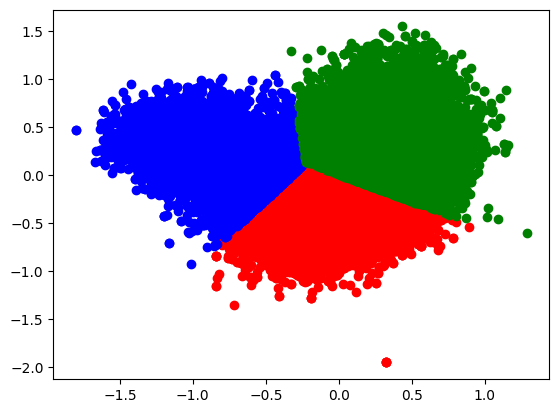

In [32]:
import matplotlib.pyplot as plt
plt.scatter(label_0[:, 0], label_0[:, 1], color='red')
plt.scatter(label_1[:, 0], label_1[:, 1], color='blue')
plt.scatter(label_2[:, 0], label_2[:, 1], color='green')
plt.show()


In [ ]:
# nb = NaiveBayes()
# nbModel = nb.fit(train)
# nbModel.save("nbm.model")

In [ ]:
#QABert
# from sparknlp import MultiDocumentAssembler
# document_assembler = MultiDocumentAssembler().setInputCols(["question", "context"]).setOutputCols(["document_question", "document_context"])

# spanClassifier = BertForQuestionAnswering.pretrained("bert_qa_bert_large_cased_whole_word_masking_finetuned_squad","en") \
# .setInputCols(["document_question", "document_context"]) \
# .setOutputCol("answer") \
# .setCaseSensitive(True)

# pipeline = Pipeline().setStages([
# document_assembler,
# spanClassifier
# ])

# example = spark.createDataFrame([["What's my name?", "My name is Clara and I live in Berkeley."]]).toDF("question", "context")

# result = pipeline.fit(example).transform(example)

In [ ]:
#Word2Vec -> KMeans
#keyword, question type, question, answer length